# Vision Description for blind aid using LSTM

### Problem Statement : Receive an image as input and produces a relevant caption or short desription for that.

Requisites : Knowledge in MLP, CNN, RNN, LSTM, Transfer Learning, Gradient Descent, Backpropagation, NLP, Keras libraries

### Dataset

There are many open source datasets available for this problem, like Flickr 8k (containing8k images), Flickr 30k (containing 30k images) etc. For the purpose of this case study, I have used the Flickr 8k dataset which we can download either from Kaggle or by filling the form provided by the University of Illinois at Urbana-Champaign. 
Kaggle : https://www.kaggle.com/datasets/adityajn105/flickr8k
Form link : https://forms.illinois.edu/sec/1713398

In [1]:
# import necessary libraries

import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
import pickle
from pickle import dump, load
from time import time

import tensorflow
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Embedding, Bidirectional, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

In [15]:
# Once we download the data, folder contains images and a text file which contains the name of each image along with its 5 captions. 
# We can read this file as follows
# Each image has corresponding to 5 captions where all are relevant.

In [21]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

filename= "./image captioning/captions.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:845])

1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .
1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a wooden cabin .
1001773457_577c3a7d70.jpg,A black dog and a spotted dog are fighting
1001773457_577c3a7d70.jpg,A black dog and a tri-colored dog playing with each other on the road .
1001773457_577c3a7d70.jpg,A black dog and a white dog with brown spots are staring at each other in the street .
1001773457_577c3a7d70.jpg,Two dogs of different breeds looking at each other on the road .
1001773457_577c3a7d70.jpg,Two dogs on pavement moving toward each other .


In [ ]:
## Note that there are five captions for each image

Lets create a dictionary named “descriptions” which contains the name of the image (without the .jpg extension) as keys and a list of the 5 captions for the corresponding image as values.

In [37]:
def load_descriptions(doc):
    mapping = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        if len(line) < 2:
            continue
        # take the first token as the image id, the rest as the description
        image_id, image_desc = tokens[0], tokens[1:]
        # extract filename from image id
        image_id = image_id.split('.')[0] # removing jpeg extention
        # convert description tokens back to string
        image_desc = ' '.join(image_desc)
        # create the list if needed
        if image_id not in mapping:
            mapping[image_id] = list() # define the dict value should be a list, so that we can append all 5 captions
        # store description
        mapping[image_id].append(image_desc)
    return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8091 


In [38]:
list(descriptions.keys())[:5]

['1000268201_693b08cb0e',
 '1001773457_577c3a7d70',
 '1002674143_1b742ab4b8',
 '1003163366_44323f5815',
 '1007129816_e794419615']

In [39]:
descriptions['1022975728_75515238d8']

['black dog running in the surf .',
 'black lab with tags frolicks in the water .',
 'dog splashes in the water',
 'black dog runs through the water .',
 'is a black dog splashing in the water .']

In [40]:
descriptions['3425918361_3b890d9575']

['small boy wearing a red helmet rides his bicycle down a patterned path .',
 'toddler rides his little bicycle down a paved path .',
 'young boy in a red helmet bikes through a park .',
 'young boy riding a bike on a brick road',
 'young boy wearing a blue shirt and a red helmet riding a bike on a sidewalk']

## Data cleaning and preprocessing - Captions

In [41]:
def clean_descriptions(descriptions):
    # prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # tokenize
            desc = desc.split()
            # convert to lower case
            desc = [word.lower() for word in desc]
            # remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # remove hanging 's' and 'a'
            desc = [word for word in desc if len(word)>1]
            # remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # store as string
            desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [ ]:
# Lets create a vocabulary of all the unique words present across all the 8000*5 (i.e. 40000) image captions (corpus)

In [42]:
# convert the loaded descriptions into a vocabulary of words
def vocabulary(descriptions):
    # build a list of all description strings
    all_desc = set()
    for key in descriptions.keys():
        [all_desc.update(d.split()) for d in descriptions[key]]
    return all_desc

# summarize vocabulary
vocabulary = vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 8680


This means we have 8680 unique words across all the 40000 image captions. We write all these captions along with their image names in a new file name, “descriptions.txt” and save it on the disk.

In [43]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + ' ' + desc)
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

save_descriptions(descriptions, 'descriptions.txt')

#### Note :
The text file “train_image_names.txt” contains the names of the images that belong to the training set. So we load these names into a list “train”.

In [83]:
# load a pre-defined list of photo identifiers
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

# load training dataset (6K)
filename = './train_image_names.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

for i in train:
    print(i, end=" ")
    break

Dataset: 6000
3296584432_bef3c965a3 

Thus we have separated the 6000 training images in the list named “train”.

In [6]:
# Below path contains all the images
images = '.\image captioning\Images/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.jpg')

In [58]:
print(type(img))
print(len(img))
print(img[0])

<class 'list'>
8091
.\image captioning\Images\1000268201_693b08cb0e.jpg


In [7]:
# Below file conatains the names of images to be used in train data
train_images_file = './train_image_names.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))
print(type(train_images))
print(len(train_images))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

<class 'set'>
6000


In [75]:
print(type(train_img))
print(len(train_img))
print(train_img[0])

<class 'list'>
6000
.\image captioning\Images\1000268201_693b08cb0e.jpg


In [76]:
# Below file contains the names of images to be used in test data
test_images_file = './test_image_names.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

#### Note : 
Now, we load the descriptions of these images from “descriptions.txt” (saved on the hard disk) in to a dictionary “train_descriptions”.

However, when we load them, we will add two tokens in every caption as follows:

‘startseq’ -> This is a start sequence token which will be added at the start of every caption.

‘endseq’ -> This is an end sequence token which will be added at the end of every caption.

In [88]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
    # load document
    doc = load_doc(filename)
    descriptions = dict()
    for line in doc.split('\n'):
        # split line by white space
        tokens = line.split()
        # split id from description
        image_id, image_desc = tokens[0], tokens[1:]
        # skip images not in the set
        if image_id in dataset:
            # create list
            if image_id not in descriptions:
                descriptions[image_id] = list()
            # wrap description in tokens
            desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
            # store
            descriptions[image_id].append(desc)
    return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [89]:
print(train_descriptions['1000268201_693b08cb0e'])

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq']


#### Note:
There is one parameter that we need to calculate, i.e., the maximum length of a caption

In [116]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
    all_desc = list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
    lines = to_lines(descriptions)
    return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 33


### Note :
Captions are something that we want to predict. So during the training period, captions will be the target variables (Y) that the model is learning to predict.

But the prediction of the entire caption, given the image does not happen at once. We will predict the caption word by word. Thus, we need to encode each word into a fixed sized vector.

In [107]:
# First create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

30000

In [173]:
print(all_train_captions)

['startseq child in pink dress is climbing up set of stairs in an entry way endseq', 'startseq girl going into wooden building endseq', 'startseq little girl climbing into wooden playhouse endseq', 'startseq little girl climbing the stairs to her playhouse endseq', 'startseq little girl in pink dress going into wooden cabin endseq', 'startseq black dog and spotted dog are fighting endseq', 'startseq black dog and tricolored dog playing with each other on the road endseq', 'startseq black dog and white dog with brown spots are staring at each other in the street endseq', 'startseq dogs of different breeds looking at each other on the road endseq', 'startseq dogs on pavement moving toward each other endseq', 'startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq', 'startseq little girl is sitting in front of large painted rainbow endseq', 'startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it en

### Note :
However, if we think about it, many of these words will occur very few times, say 1, 2 or 3 times. Since we are creating a predictive model, we would not like to have all the words present in our vocabulary but the words which are more likely to occur or which are common. This helps the model become more robust to outliers and make less mistakes.
Hence we consider only those words which occur at least 10 times in the entire corpus.

In [108]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 7603 -> 1652


#### Note:
So now we have only 1651 unique words in our vocabulary. However, we will append 0’s (zero padding explained later) and thus total words = 1651+1 = 1652 (one index for the 0).

Next we will create two Python Dictionaries namely “wordtoix” (pronounced — word to index) and “ixtoword” (pronounced — index to word).

Stating simply, we will represent every unique word in the vocabulary by an integer (index). As seen above, we have 1652 unique words in the corpus and thus each word will be represented by an integer index between 1 to 1652.

These two Python dictionaries can be used as follows:

wordtoix[‘abc’] -> returns index of the word ‘abc’

ixtoword[k] -> returns the word whose index is ‘k’

In [109]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [110]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

1653

## Data Preprocessing - Images

#### Note :
Images are nothing but input (X) to our model and any input to a model must be given in the form of a vector.

We need to convert every image into a fixed sized vector which can then be fed as input to the neural network. For this purpose, we opt for transfer learning by using the InceptionV3 model (Convolutional Neural Network) created by Google Research. We can experiment the performance using otehr models like VGG16/19 etc.

This model was trained on Imagenet dataset to perform image classification on 1000 different classes of images. However, our purpose here is not to classify the image but just get fixed-length informative vector for each image. This process is called automatic feature engineering.

Hence, we just remove the last softmax layer from the model and extract a 2048 length vector (bottleneck features) for every image. 

In [37]:
def preprocess(image_path):
    '''
    img1 = image.load_img(image_path)
    y = image.img_to_array(img1)
    print("shape of one train image : ", y.shape)  # Output (500, 375, 3)
    '''
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    #print("type of x : ",type(x))  # Output <class 'numpy.ndarray'>
    #print("shape of x : ",x.shape) # Output : (299, 299, 3)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    #print("shape of of x with new dim : ",x.shape) # Output : (1, 299, 299, 3)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

In [38]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    # print(fea_vec.shape)  # Output : (1,2048)
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [17]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')

In [18]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [39]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
'''
for img in train_img:
    print("[img[len(images):] : ", [img[len(images):]]) # Output : ['1000268201_693b08cb0e.jpg']
    encoding_train[img[len(images):]] = encode(img)
    break
'''
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)

print("Time taken in seconds =", time()-start)

Time taken in seconds = 992.6849467754364


In [42]:
len(encoding_train['1000268201_693b08cb0e.jpg'])

2048

#### Note :
We save all the bottleneck train features in a Python dictionary and save it on the disk using Pickle file, namely “encoded_train_images.pkl” whose keys are image names and values are corresponding 2048 length feature vector.

In [102]:
# Save the bottleneck train features to disk
with open("./encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

#### Note :
Similarly we encode all the test images and save them in the file “encoded_test_images.pkl”.

In [103]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 181.02749919891357


In [105]:
# Save the bottleneck test features to disk
with open("./encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

## Data Preparation using Generator Function

This is one of the most important steps in this case study. Here we will understand how to prepare the data in a manner which will be convenient to be given as input to the deep learning model.
#### Refer README for the detailed description

In [117]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

### Word Embeddings

In [128]:
# Load Glove vectors
glove_dir = './glove_embedding'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [130]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in our vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))  # creates amtrix of dim [1653 X 200]

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [131]:
embedding_matrix.shape

(1653, 200)

### Model Architecture

In [135]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)
#decoder1 = add([fe2, se3])
decoder1 = tensorflow.keras.layers.Add()([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

In [136]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 33)]         0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 33, 200)      330600      ['input_9[0][0]']                
                                                                                                  
 dropout_6 (Dropout)            (None, 2048)         0           ['input_8[0][0]']                
                                                                                            

In [138]:
model.layers[1]

In [137]:
model.layers[2]

In [140]:
model.layers[6]

In [142]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

# Notice that since we are using a pre-trained embedding layer, we need to freeze it (trainable = False), 
# before training the model, so that it does not get updated during the backpropagation.

In [143]:
model.compile(loss='categorical_crossentropy', optimizer='adam')  # Note: default learning rate of adam optimizer is 0.001

In [144]:
epochs = 10
number_pics_per_batch = 3
steps = len(train_descriptions)//number_pics_per_batch

In [146]:
train_features = load(open(".//encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [147]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_batch)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

<ipython-input-147-39ab4f485aa0>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


2000/2000 [==============================] - 554s 274ms/step - loss: 4.2054


C:\Users\saras\anaconda3\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2000/2000 [==============================] - 504s 252ms/step - loss: 2.7954


In [163]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    model.save('./model_weights/model_' + str(i) + '.h5')

<ipython-input-163-5917c57d8a84>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


1000/1000 [==============================] - 452s 452ms/step - loss: 2.5426


In [148]:
model.optimizer.lr = 0.0001
epochs = 10
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [149]:
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
    model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)
    #model.save('./model_weights/model_' + str(i) + '.h5')

<ipython-input-149-91cce8c55713>:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1)


1000/1000 [==============================] - 501s 501ms/step - loss: 2.5990


In [164]:
model.save_weights('./model_weights/2_stages_model.h5')

## Evaluation and inference of model

In [165]:
model.load_weights('./model_weights/2_stages_model.h5')

In [166]:
images = './Image captioning/Images/'

In [167]:
with open("./encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [168]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

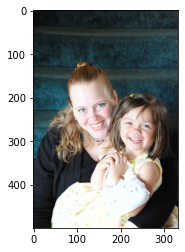

Greedy: young girl is sitting on the ground and smiles


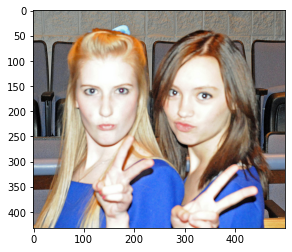

Greedy: women in black are posing for picture


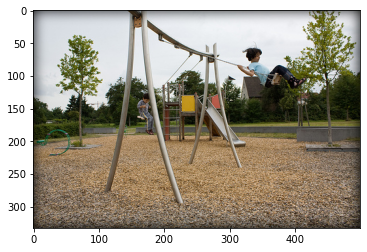

Greedy: little girl in pink is jumping off of swing


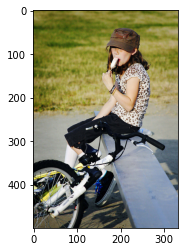

Greedy: man in blue shirt and helmet is riding bicycle


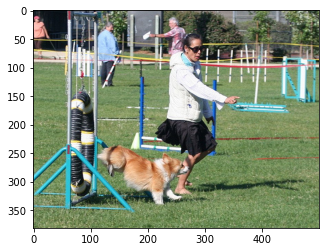

Greedy: dog is running through the grass


In [169]:
z=[10,128,999,571,733]
for i in z:
    pic = list(encoding_test.keys())[i]
    image = encoding_test[pic].reshape((1,2048))
    x=plt.imread(images+pic)
    plt.imshow(x)
    plt.show()
    print("Greedy:",greedySearch(image))

In [2]:
import gensim
from gensim.models import Word2Vec

ValueError: numpy.ndarray size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject